In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams.update({'font.size': 18})
import utils
from scipy.optimize import leastsq
from collections import defaultdict
from scipy.interpolate import InterpolatedUnivariateSpline

### Load the data

In [3]:
data = pd.read_csv('data/train.csv', index_col= 'id')
data.head(3)

,epoch,sat_id,x,y,z,Vx,Vy,Vz,x_sim,y_sim,z_sim,Vx_sim,Vy_sim,Vz_sim
id,,,,,,,,,,,,,,
0,2014-01-01T00:00:00.000,0,-8855.823863,13117.780146,-20728.353233,-0.908303,-3.808436,-2.022083,-8843.131454,13138.221690,-20741.615306,-0.907527,-3.804930,-2.024133
1,2014-01-01T00:46:43.000,0,-10567.672384,1619.746066,-24451.813271,-0.302590,-4.272617,-0.612796,-10555.500066,1649.289367,-24473.089556,-0.303704,-4.269816,-0.616468
2,2014-01-01T01:33:26.001,0,-10578.684043,-10180.467460,-24238.280949,0.277435,-4.047522,0.723155,-10571.858472,-10145.939908,-24271.169776,0.274880,-4.046788,0.718768


### Difference between simulated and real values

Text(0, 0.5, 'x')

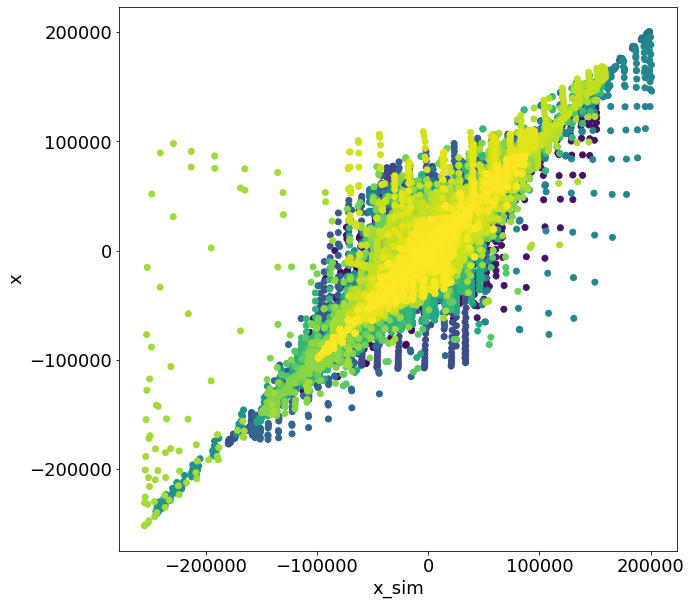

In [7]:
# see how different the simulated coordinates from predicted
plt.figure(figsize=(10,10))
plt.scatter(data.x_sim,data.x,c=data.sat_id)
plt.xlabel("x_sim")
plt.ylabel("x")

Text(0, 0.5, 'Vx')

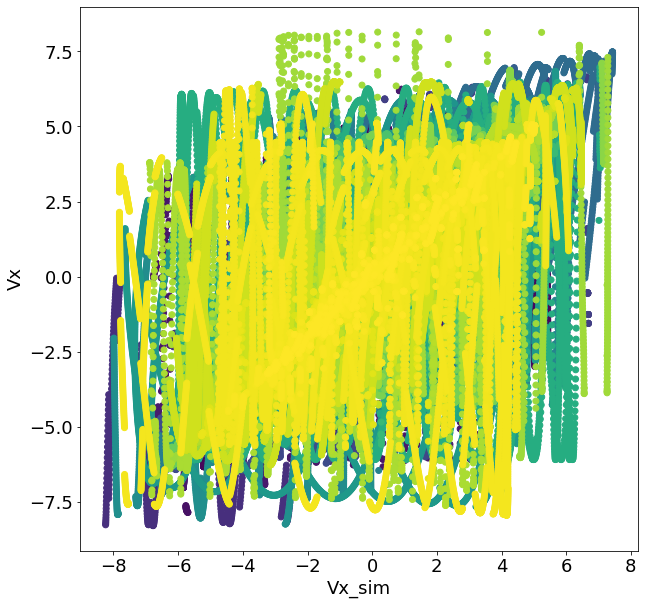

In [8]:
# see how different the simulated coordinates from predicted
plt.figure(figsize=(10,10))
plt.scatter(data.Vx_sim,data.Vx,c=data.sat_id)
plt.xlabel("Vx_sim")
plt.ylabel("Vx")

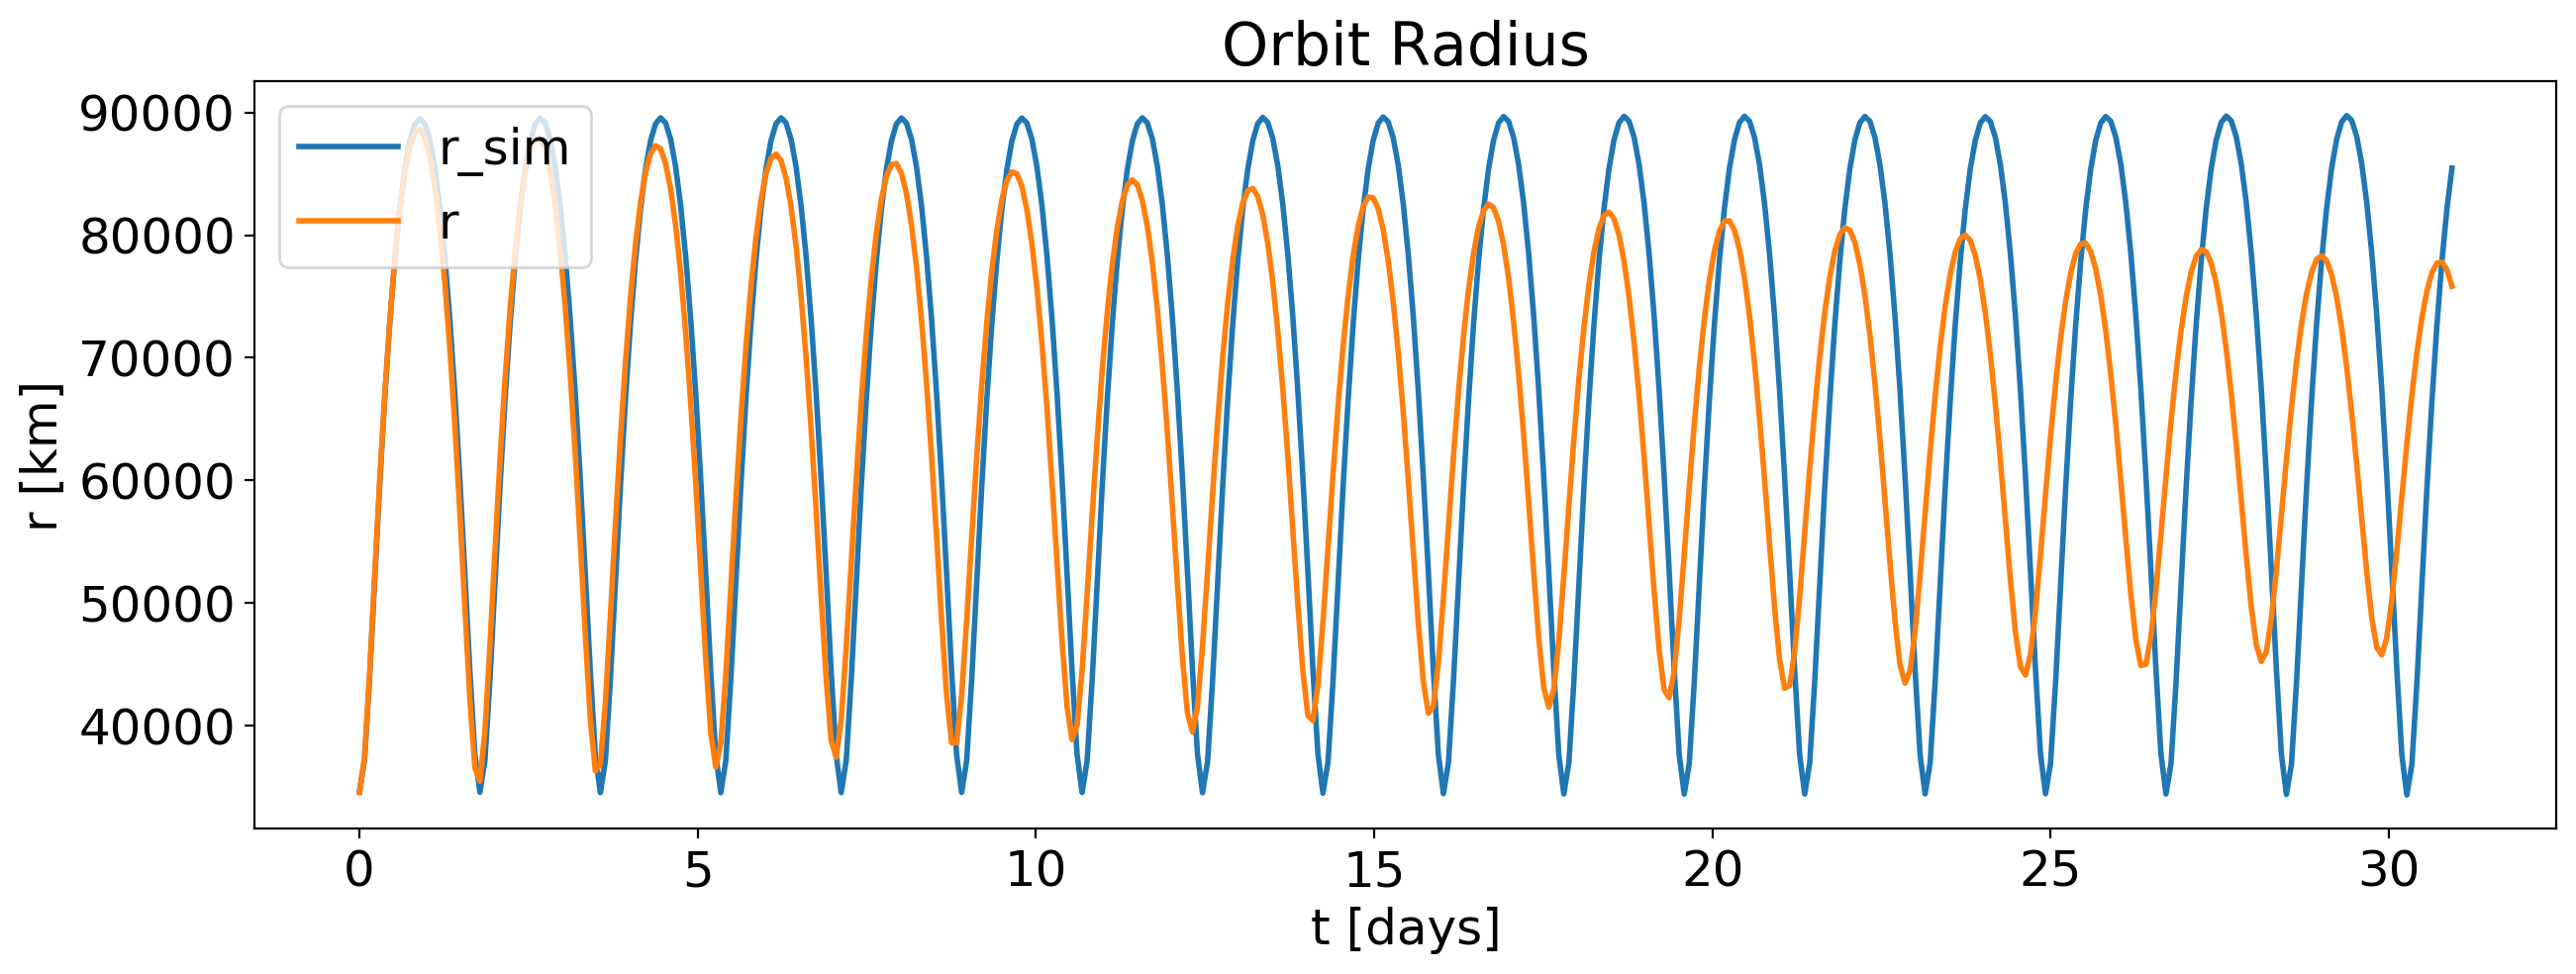

In [117]:
# low let's consider the time series
sat_data = data[data.sat_id == 6]
sat_data.loc[:,'t'] = ((pd.to_datetime(sat_data['epoch']) - pd.to_datetime(sat_data['epoch']).iloc[0]) /
                           np.timedelta64(1, 'D')).astype(float).values
sat_data.loc[:,'r'] = np.sqrt(sat_data.x**2+sat_data.y**2+sat_data.z**2)
sat_data.loc[:,'r_sim'] = np.sqrt(sat_data.x_sim**2+sat_data.y_sim**2+sat_data.z_sim**2)
plt.figure(figsize=(15,5), dpi = 200)
plt.plot(sat_data.t, sat_data.r_sim, label = 'r_sim', linewidth = 2)
plt.plot(sat_data.t, sat_data.r, label = 'r', linewidth = 2)
_ = plt.xlabel('t [days]')
_ = plt.ylabel('r [km]')
_ = plt.title('Orbit Radius')
# _ = plt.xlim([-5,30])
plt.legend(loc = 2)

### Time jumps

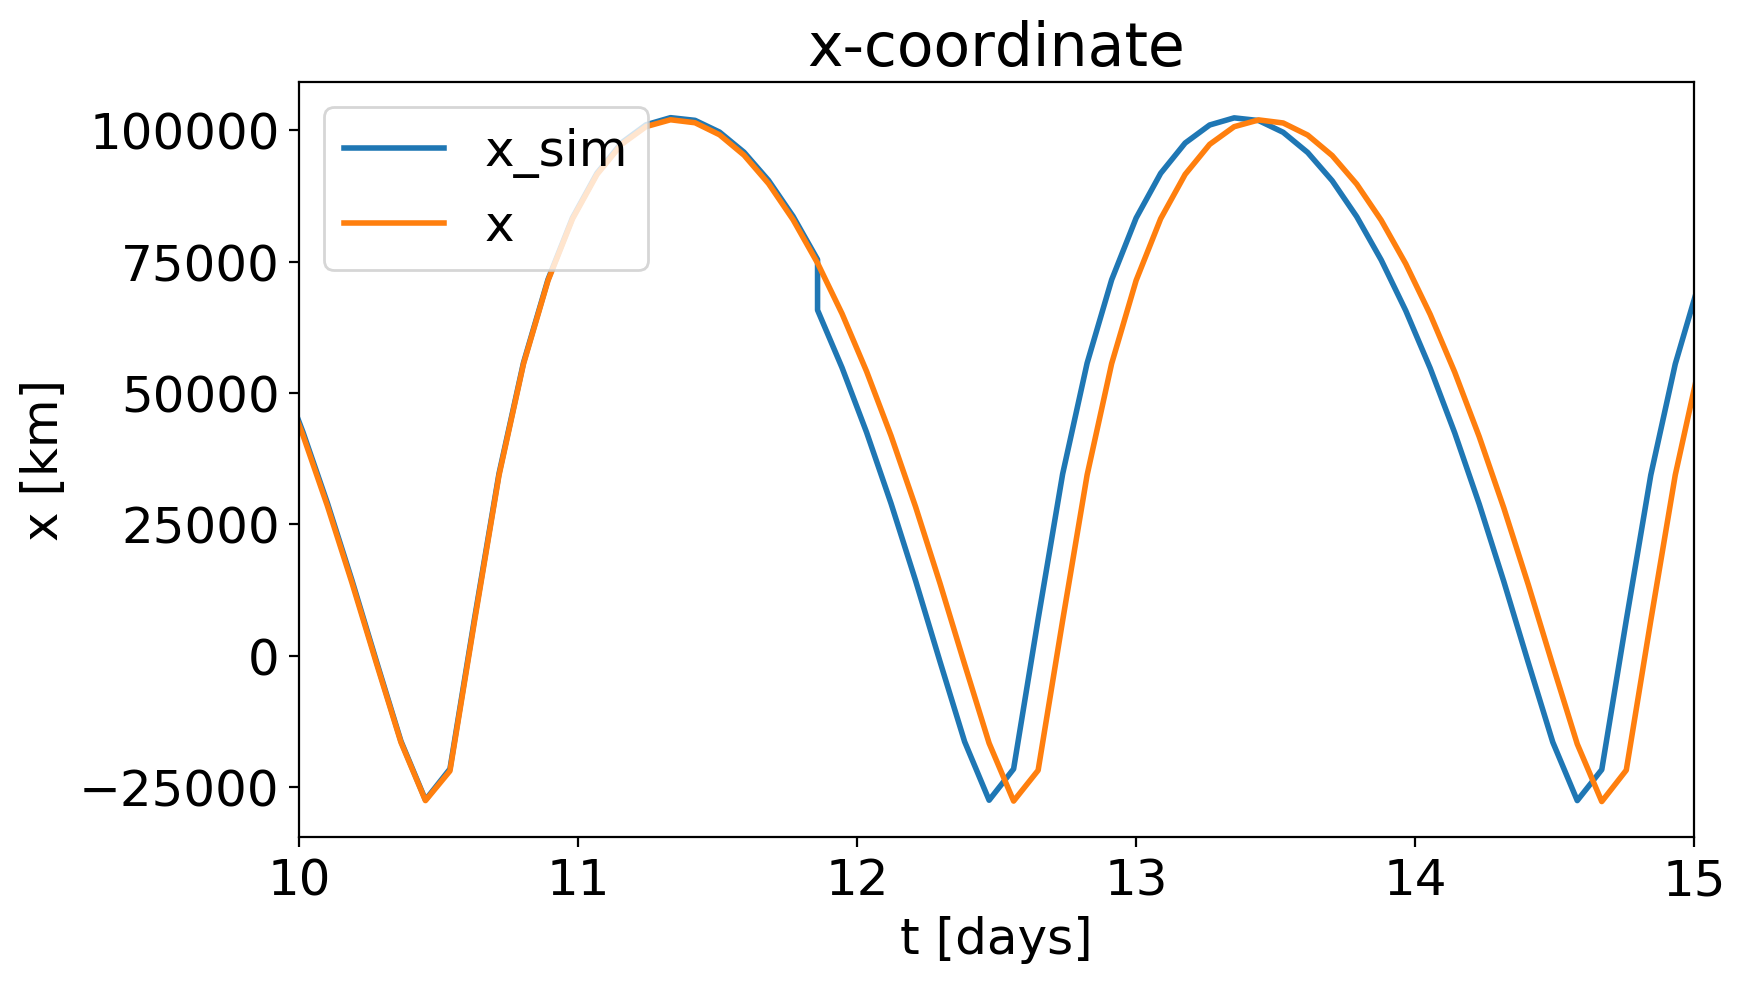

In [119]:
sat_data = data[data.sat_id == 3]
sat_data.loc[:,'t'] = ((pd.to_datetime(sat_data['epoch']) - pd.to_datetime(sat_data['epoch']).iloc[0]) /
                           np.timedelta64(1, 'D')).astype(float).values
sat_data.loc[:,'r'] = np.sqrt(sat_data.x**2+sat_data.y**2+sat_data.z**2)
sat_data.loc[:,'r_sim'] = np.sqrt(sat_data.x_sim**2+sat_data.y_sim**2+sat_data.z_sim**2)
plt.figure(figsize=(9,5), dpi = 200)
plt.plot(sat_data.t, sat_data.x_sim, label = 'x_sim', linewidth = 2)
plt.plot(sat_data.t, sat_data.x, label = 'x', linewidth = 2)
_ = plt.xlabel('t [days]')
_ = plt.ylabel('x [km]')
_ = plt.title('x-coordinate')
_ = plt.xlim([10,15])
plt.legend(loc = 2)

### Distribution of orbit radii 

In [91]:
data['radius'] = np.sqrt(data.x**2+data.y**2+data.z**2)
data['radius_sim'] = np.sqrt(data.x_sim**2+data.y_sim**2+data.z_sim**2)

data['speed'] = np.sqrt(data.Vx**2+data.Vy**2+data.Vz**2)
data['speed_sim'] = np.sqrt(data.Vx_sim**2+data.Vy_sim**2+data.Vz_sim**2)

In [92]:
orbits = data.groupby('sat_id').agg({'radius':['max','min','mean'],
                                     'radius_sim':['max','min','mean'],
                                     'speed':['max','min','mean'],
                                     'speed_sim':['max','min','mean'],
                                     'epoch':['count']
                                    })
orbits.head()

radius                                 radius_sim  \
                  max           min          mean            max   
sat_id                                                             
0        45456.138231  26055.667966  37089.673093   45435.618165   
1        33145.178842   9480.338813  24043.492758   30996.602074   
2        88525.178417  35946.367097  67593.872562   88483.865249   
3       113037.471222  25800.000000  83386.906541  113128.505398   
4        40864.306203  20345.080776  32285.104148   40856.798043   

                                       speed                     speed_sim  \
                 min          mean       max       min      mean       max   
sat_id                                                                       
0       26066.565345  37078.116172  4.409858  2.527665  3.274538  4.408323   
1       11221.720940  23437.131825  8.074972  2.274235  4.023999  7.222133   
2       35999.113542  67569.020677  3.971576  1.613108  2.421667  3.967548   
3       25746.357849  83402.369379  5.015947  1.145381  2.130393  5.022338   
4       20345.825704  32296.162950  5.114521  2.546358  3.509986  5.114330   

                           epoch  
             min      mean count  
sat_id                            
0       2.529023  3.275160   958  
1       2.614980  4.093842  2108  
2       1.614284  2.422313   417  
3       1.143397  2.130242   354  
4       2.546816  3.508198  1210

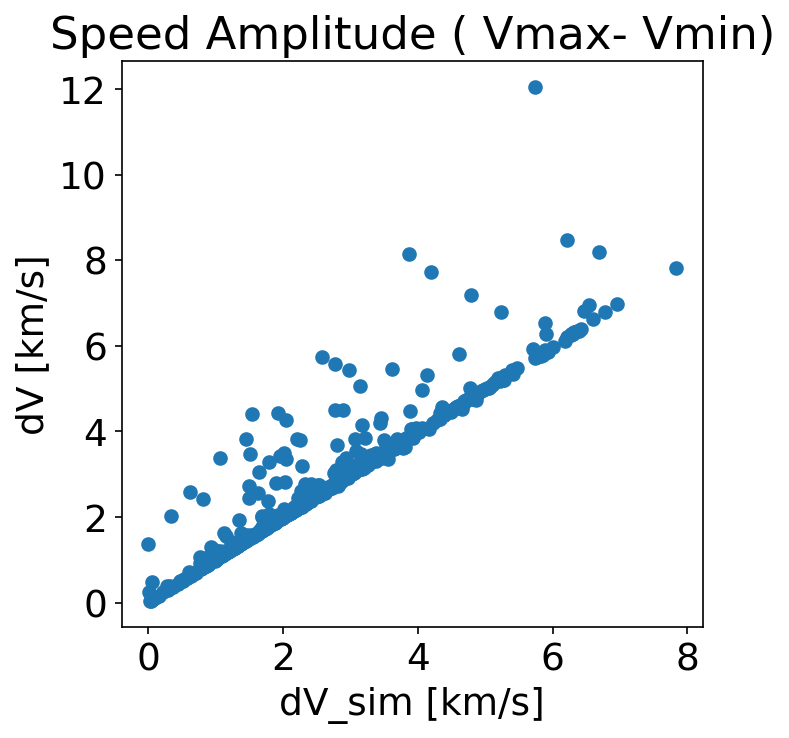

In [105]:
plt.figure(figsize=(5,5), dpi = 150)
plt.scatter(orbits.speed_sim['max']- orbits.speed_sim['min'],orbits.speed['max']-orbits.speed['min'])
_ = plt.xlabel('dV_sim [km/s]')
_ = plt.ylabel('dV [km/s]')
_ = plt.title('Speed Amplitude ( Vmax- Vmin)')

### 2D plots of the orbits

In [127]:
def plot_orbits(m_id,n_points):
    m_data = data[data.sat_id == m_id]


    r = np.sqrt(m_data.x**2+m_data.y**2+m_data.z**2)
    r_sim = np.sqrt(m_data.x_sim**2+m_data.y_sim**2+m_data.z_sim**2)
    speed = np.sqrt(m_data.Vx**2+m_data.Vy**2+m_data.Vz**2)
    speed_sim = np.sqrt(m_data.Vx_sim**2+m_data.Vy_sim**2+m_data.Vz_sim**2)

    f, (ax1,ax2,ax3, ax4) = plt.subplots(1,4,figsize = (20,7), dpi = 150)

    ax1.scatter(m_data[-n_points:].z,m_data[-n_points:].x, label = 'end real')
    ax1.scatter(m_data[-n_points:].z_sim,m_data[-n_points:].x_sim, label = 'end sim')
    ax1.plot(m_data[:n_points].z,m_data[:n_points].x, label = 'start real')
    ax1.plot(m_data[:n_points].z_sim,m_data[:n_points].x_sim, label = 'start sim')
    ax1.set_title('x-z plane')


    ax2.scatter(m_data[-n_points:].z,m_data[-n_points:].y, label = 'end real')
    ax2.scatter(m_data[-n_points:].z_sim,m_data[-n_points:].y_sim, label = 'end sim')
    ax2.plot(m_data[:n_points].z,m_data[:n_points].y, label = 'start real')
    ax2.plot(m_data[:n_points].z_sim,m_data[:n_points].y_sim, label = 'start sim')
    ax2.set_title('z-y plane')

    ax3.scatter(m_data[-n_points:].y,m_data[-n_points:].x, label = 'end real')
    ax3.scatter(m_data[-n_points:].y_sim,m_data[-n_points:].x_sim, label = 'end sim')
    ax3.plot(m_data[:n_points].y,m_data[:n_points].x, label = 'start real')
    ax3.plot(m_data[:n_points].y_sim,m_data[:n_points].x_sim, label = 'start sim')
    ax3.legend()
    ax3.set_title('y-x plane')

    ax4.plot((r-r_sim)/r, label = 'position')
    ax4.plot((speed-speed_sim)/speed, label='speed')
    ax4.legend()
    ax4.set_title('relative r error')


    plt.tight_layout()

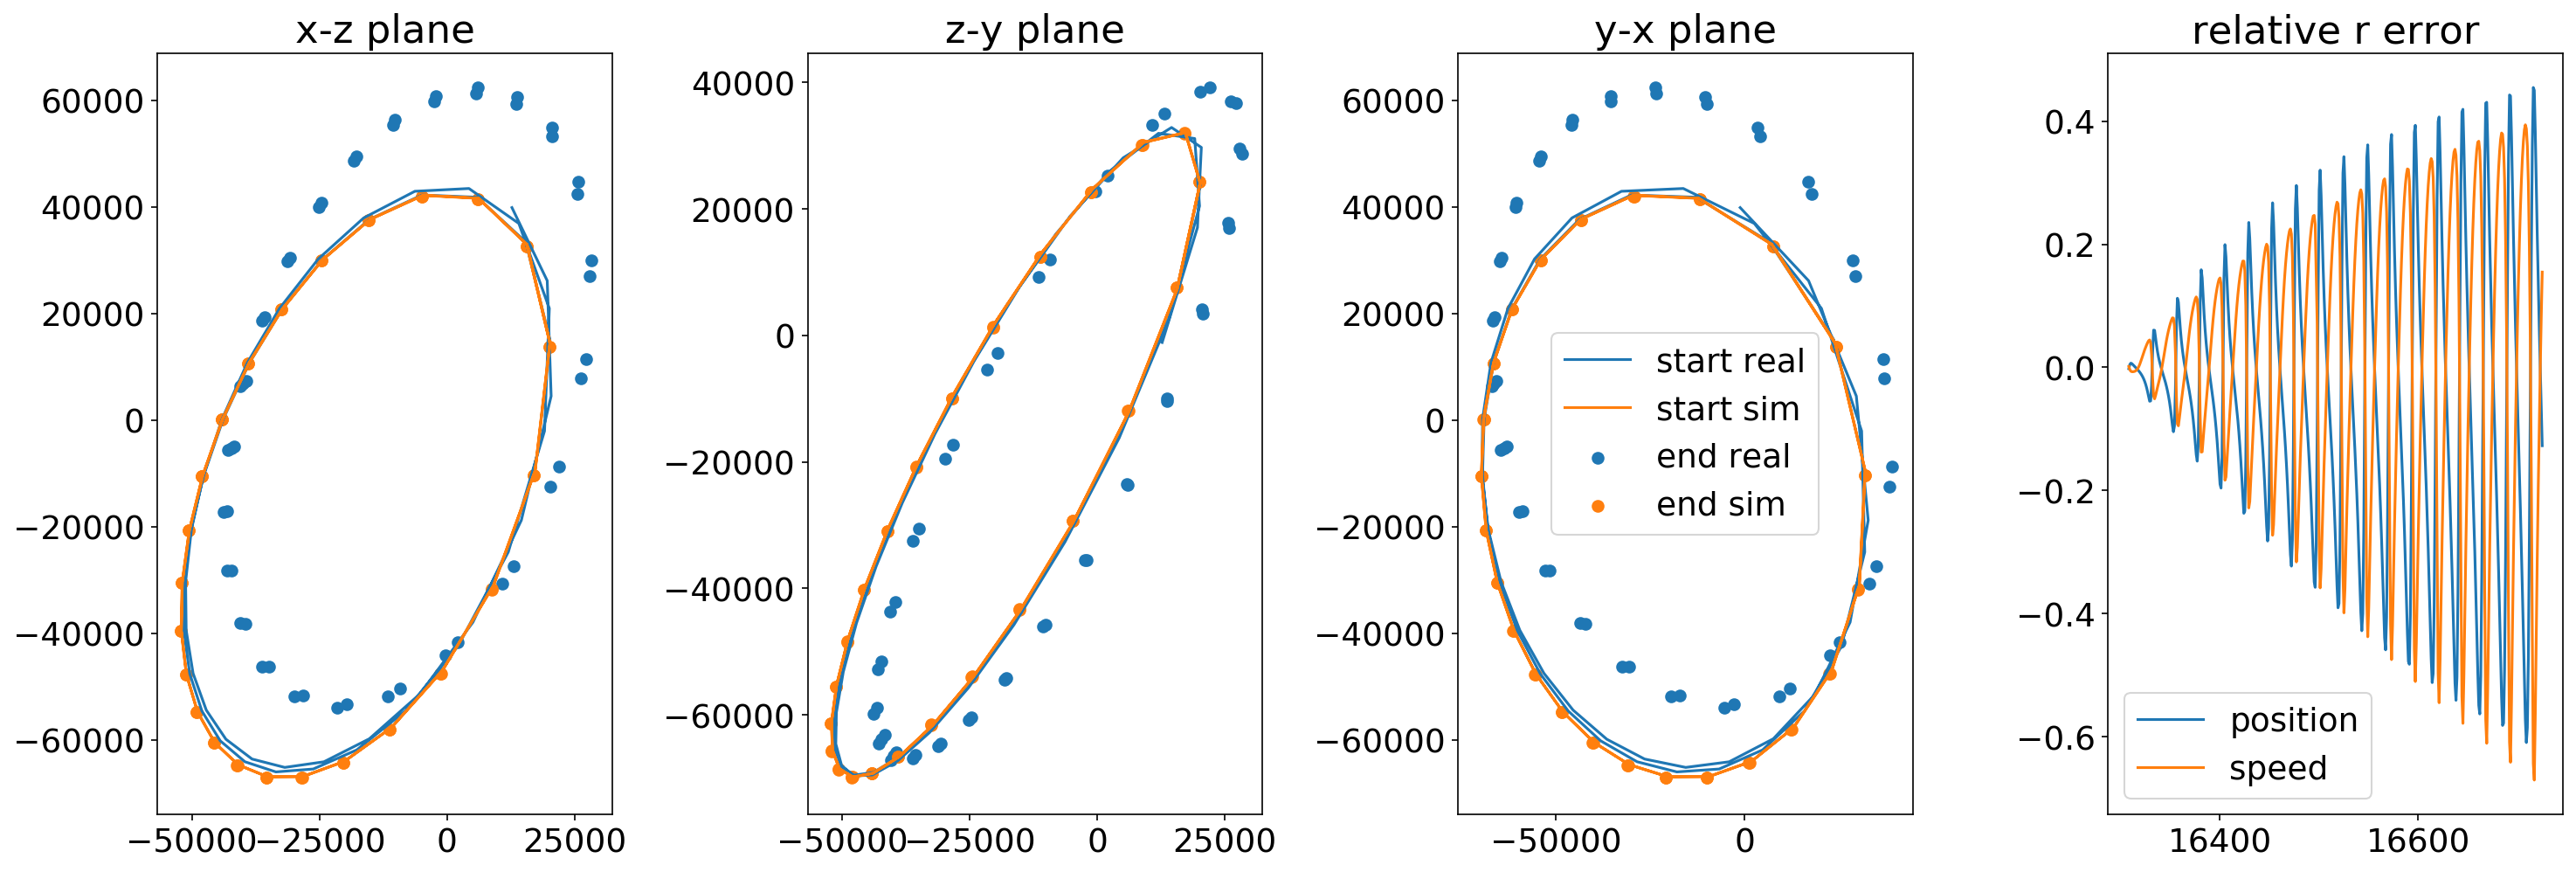

In [132]:
plot_orbits(6,50)